In [16]:
# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
import matplotlib.pyplot as plt
import seaborn as sns

# Configure visual settings for plots
sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (12, 6)


In [17]:
# Load the dataset
file_path = 'C:/Users/Ashish Bhandari/Desktop/Machine Learning/Amazon Sale Report/Amazon Sale Report.csv'  # Replace with your dataset path
data = pd.read_csv(file_path)

# Clean column names
data.columns = data.columns.str.strip()

# Drop irrelevant columns
data.drop(columns=["Unnamed: 22", "fulfilled-by", "promotion-ids"], inplace=True, errors="ignore")

# Convert 'Date' column to datetime
data["Date"] = pd.to_datetime(data["Date"], errors="coerce")

# Handle missing values
numeric_cols = data.select_dtypes(include=["float64", "int64"]).columns
data[numeric_cols] = data[numeric_cols].fillna(data[numeric_cols].median())
categorical_cols = data.select_dtypes(include=["object"]).columns
data[categorical_cols] = data[categorical_cols].fillna("Unknown")


C:\Users\Ashish Bhandari\AppData\Local\Temp\ipykernel_8308\2545695932.py:3: DtypeWarning: Columns (23) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv(file_path)
C:\Users\Ashish Bhandari\AppData\Local\Temp\ipykernel_8308\2545695932.py:12: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  data["Date"] = pd.to_datetime(data["Date"], errors="coerce")


In [18]:
# Add time-based features
data["Order Month"] = data["Date"].dt.month
data["Order Year"] = data["Date"].dt.year
data["Order Day"] = data["Date"].dt.dayofweek
data["is_weekend"] = data["Order Day"].apply(lambda x: 1 if x in [5, 6] else 0)

# Add lag and rolling average features
data["sales_lag_7"] = data["Amount"].shift(7).fillna(0)
data["sales_lag_30"] = data["Amount"].shift(30).fillna(0)
data["rolling_avg_7"] = data["Amount"].rolling(window=7, min_periods=1).mean()
data["rolling_avg_30"] = data["Amount"].rolling(window=30, min_periods=1).mean()

# Add category-level aggregate features
data["avg_sales_per_category"] = data.groupby("Category")["Amount"].transform("mean")

# Add interaction feature
data["Qty_Amount_Interaction"] = data["Qty"] * data["Amount"]

# One-hot encode categorical features
categorical_features = ["Category", "Sales Channel", "ship-service-level", "Fulfilment", 
                        "Status", "Size", "Courier Status"]
data = pd.get_dummies(data, columns=categorical_features, drop_first=True)

# Standardize numeric features
scaler = StandardScaler()
numeric_features = ["Qty", "Amount", "Order Month", "Order Year", "Order Day", 
                    "sales_lag_7", "sales_lag_30", "rolling_avg_7", "rolling_avg_30", 
                    "avg_sales_per_category", "Qty_Amount_Interaction"]
data[numeric_features] = scaler.fit_transform(data[numeric_features])

# Drop unused columns
drop_columns = ["index", "Order ID", "Date", "Style", "SKU", "ASIN", "currency", 
                "ship-city", "ship-state", "ship-country", "ship-postal-code"]
data.drop(columns=drop_columns, inplace=True, errors="ignore")


In [19]:
# Separate features and target variable
X = data.drop(columns=["Amount"])
y = data["Amount"]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Align feature spaces
def align_feature_spaces(X_train, X_test):
    """
    Align feature spaces for training and testing sets.
    """
    X_test = X_test.reindex(columns=X_train.columns, fill_value=0)
    return X_train, X_test

X_train, X_test = align_feature_spaces(X_train, X_test)


In [20]:
# Define a function to train and evaluate a model
def train_and_evaluate_model(model, X_train, y_train, X_test, y_test):
    """
    Train and evaluate a machine learning model.
    """
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    return {"model": model, "rmse": rmse, "mae": mae, "r2": r2, "predictions": y_pred}


In [21]:
# Initialize models
models = {
    "Linear Regression": LinearRegression(),
    "Decision Tree": DecisionTreeRegressor(max_depth=10, random_state=42),
    "Random Forest": RandomForestRegressor(n_estimators=100, random_state=42),
    "XGBoost": XGBRegressor(random_state=42, objective='reg:squarederror', n_estimators=200, learning_rate=0.1, max_depth=5)
}

# Train and evaluate all models
results = {}
for name, model in models.items():
    results[name] = train_and_evaluate_model(model, X_train, y_train, X_test, y_test)

# Display results
comparison_table = pd.DataFrame({model: {metric: results[model][metric] for metric in ["rmse", "mae", "r2"]} for model in models.keys()}).T
comparison_table.columns = ["RMSE", "MAE", "R^2"]
comparison_table.index.name = "Model"
print(comparison_table)


                           RMSE            MAE           R^2
Model                                                       
Linear Regression  3.518065e+07  219046.548597 -1.216254e+15
Decision Tree      1.573747e-01       0.027968  9.756619e-01
Random Forest      1.583584e-01       0.026569  9.753567e-01
XGBoost            1.797290e-01       0.038591  9.682566e-01


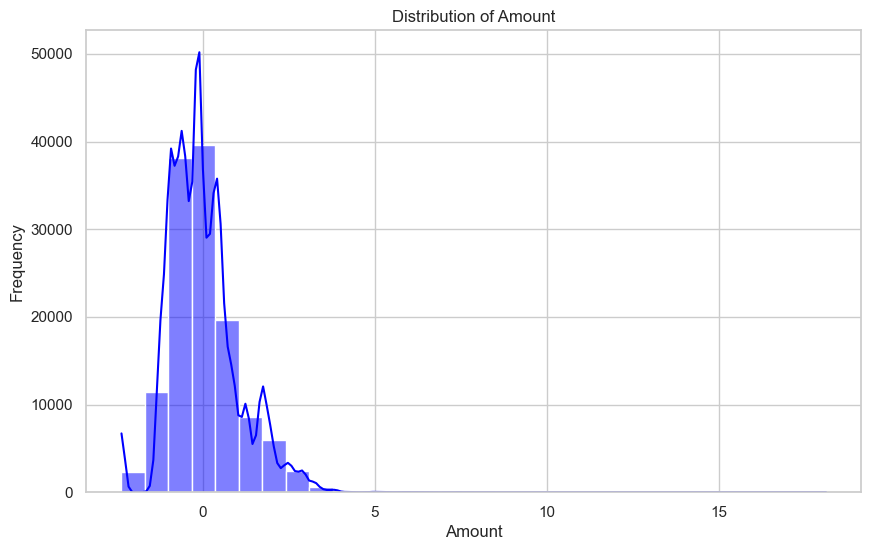

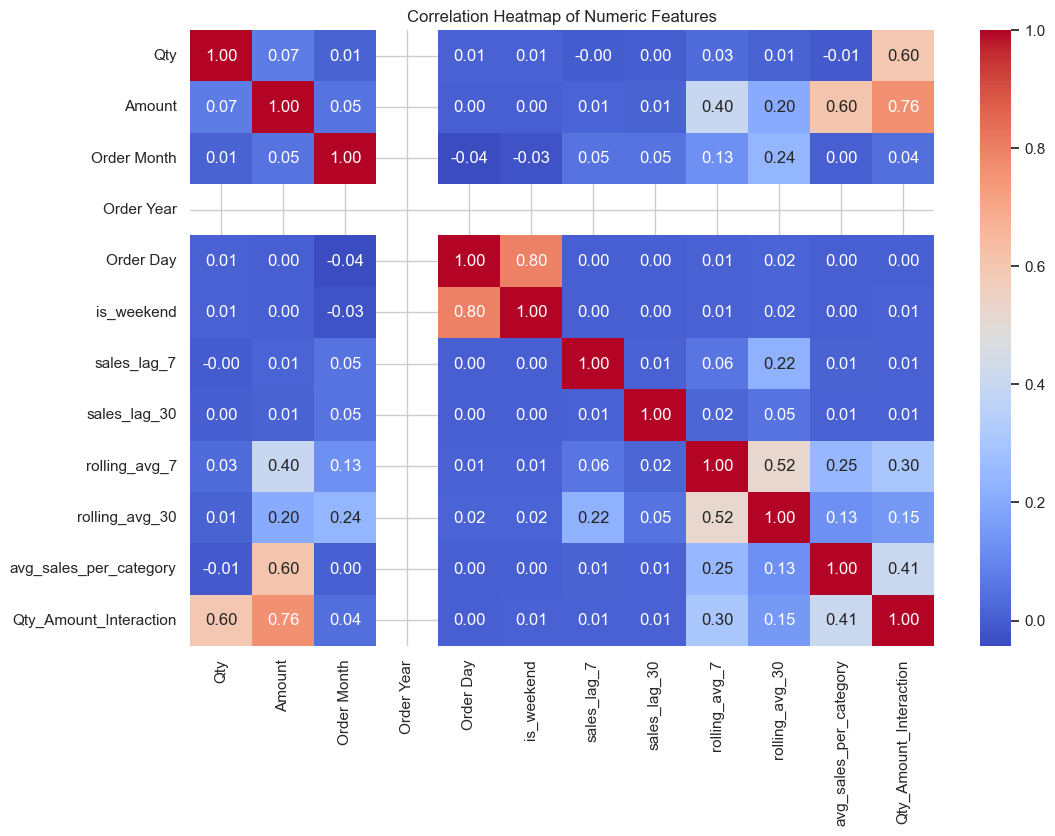

In [22]:
# Target Variable Distribution
def plot_target_distribution(data, target_column="Amount"):
    plt.figure(figsize=(10, 6))
    sns.histplot(data[target_column], kde=True, bins=30, color="blue")
    plt.title(f"Distribution of {target_column}")
    plt.xlabel(target_column)
    plt.ylabel("Frequency")
    plt.show()

# Sales Trends Over Time
def plot_sales_trend(data, date_column="Date", target_column="Amount"):
    if date_column in data.columns:
        sales_trend = data.groupby(data[date_column].dt.to_period("M"))[target_column].sum()
        sales_trend.index = sales_trend.index.to_timestamp()
        plt.figure(figsize=(12, 6))
        sales_trend.plot(kind="line", color="green", marker="o")
        plt.title("Sales Trend Over Time")
        plt.xlabel("Time")
        plt.ylabel("Total Sales")
        plt.grid(True)
        plt.show()

# Correlation Heatmap
def plot_correlation_heatmap(data, numeric_columns):
    correlation_matrix = data[numeric_columns].corr()
    plt.figure(figsize=(12, 8))
    sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f")
    plt.title("Correlation Heatmap of Numeric Features")
    plt.show()

# Plot visualizations
plot_target_distribution(data, target_column="Amount")
plot_sales_trend(data, date_column="Date", target_column="Amount")
numeric_columns = data.select_dtypes(include=["float64", "int64"]).columns
plot_correlation_heatmap(data, numeric_columns)


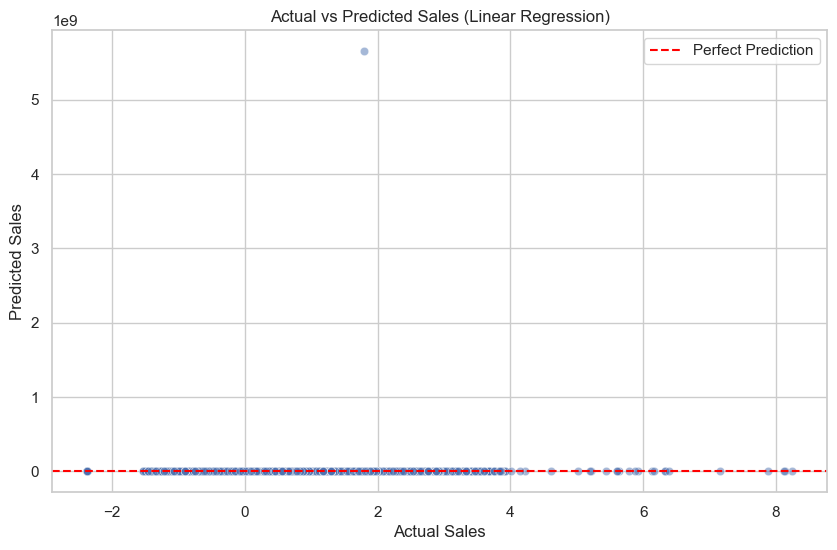

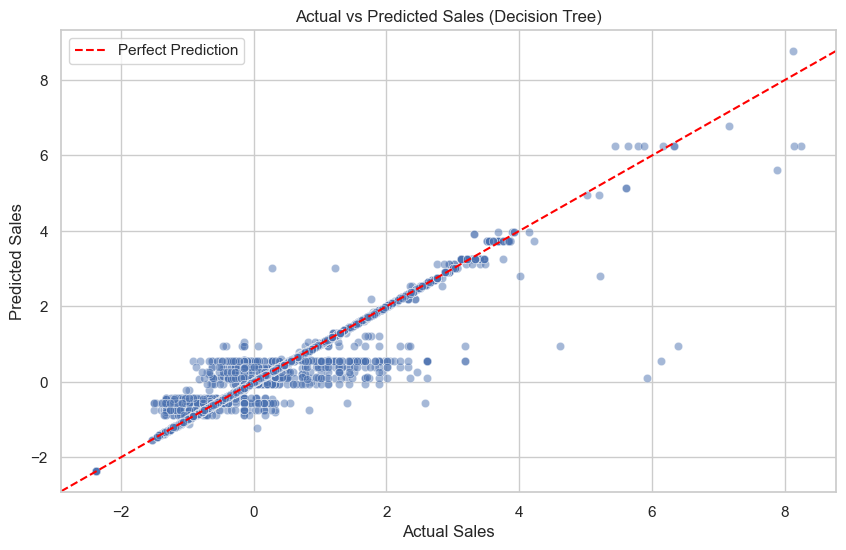

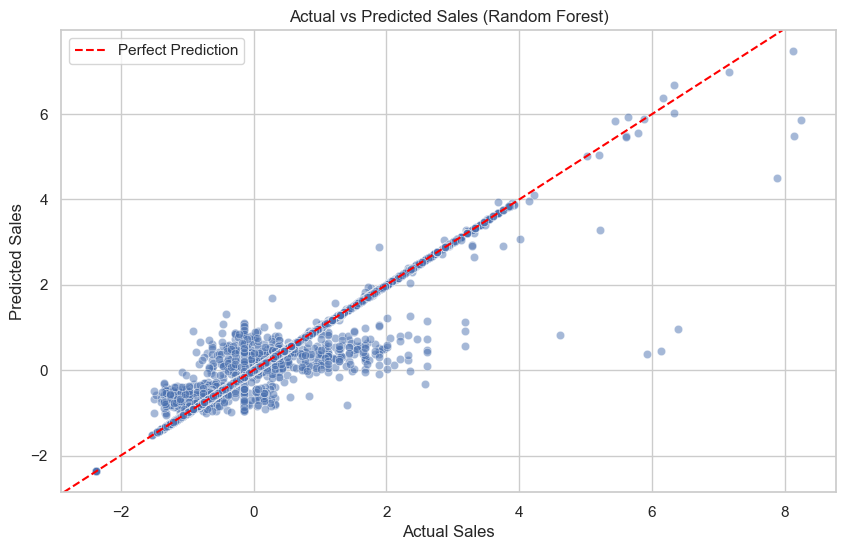

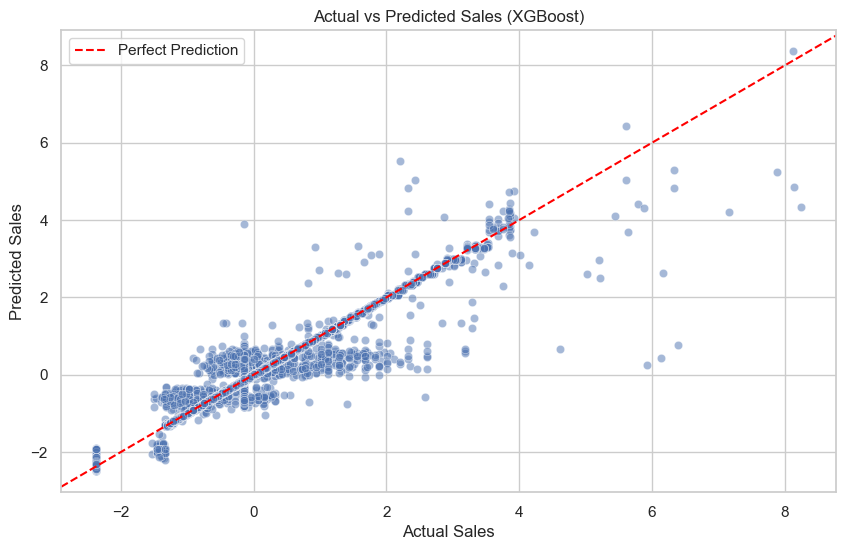

In [23]:
# Actual vs Predicted Plot
def plot_actual_vs_predicted(y_test, predictions, model_name):
    plt.figure(figsize=(10, 6))
    sns.scatterplot(x=y_test, y=predictions, alpha=0.5)
    plt.title(f"Actual vs Predicted Sales ({model_name})")
    plt.xlabel("Actual Sales")
    plt.ylabel("Predicted Sales")
    plt.axline((0, 0), slope=1, color="red", linestyle="--", label="Perfect Prediction")
    plt.legend()
    plt.show()

# Generate plots for each model
for model_name, result in results.items():
    plot_actual_vs_predicted(y_test, result["predictions"], model_name)


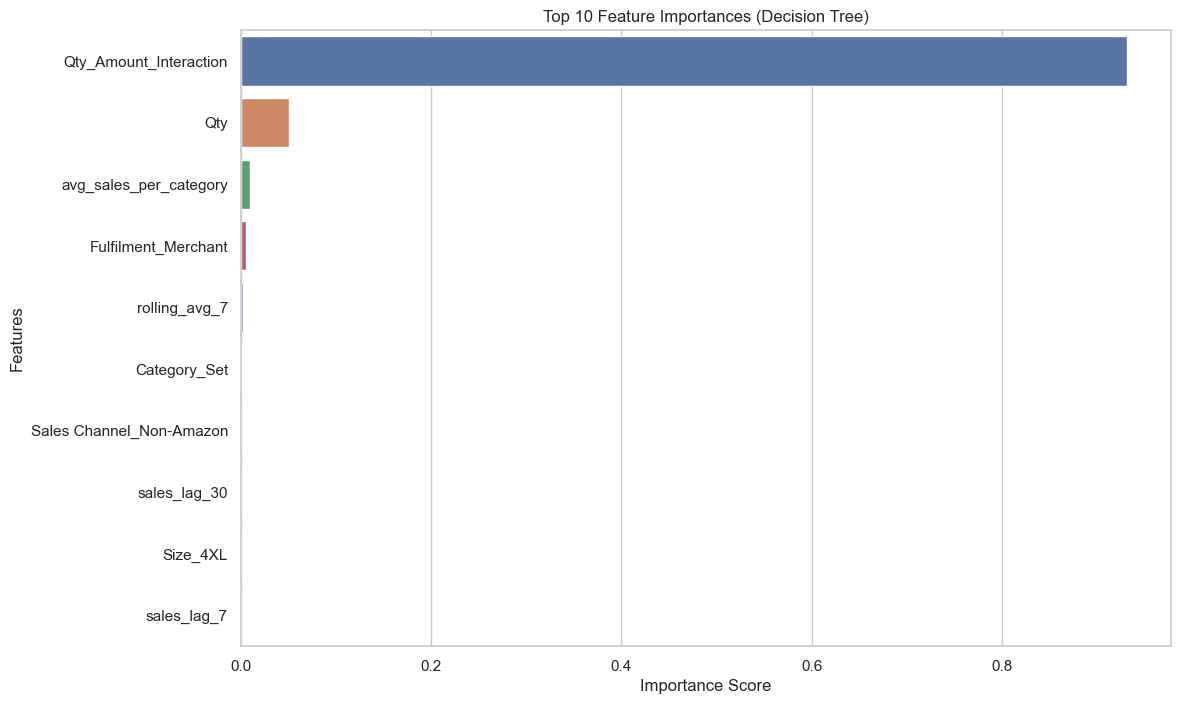

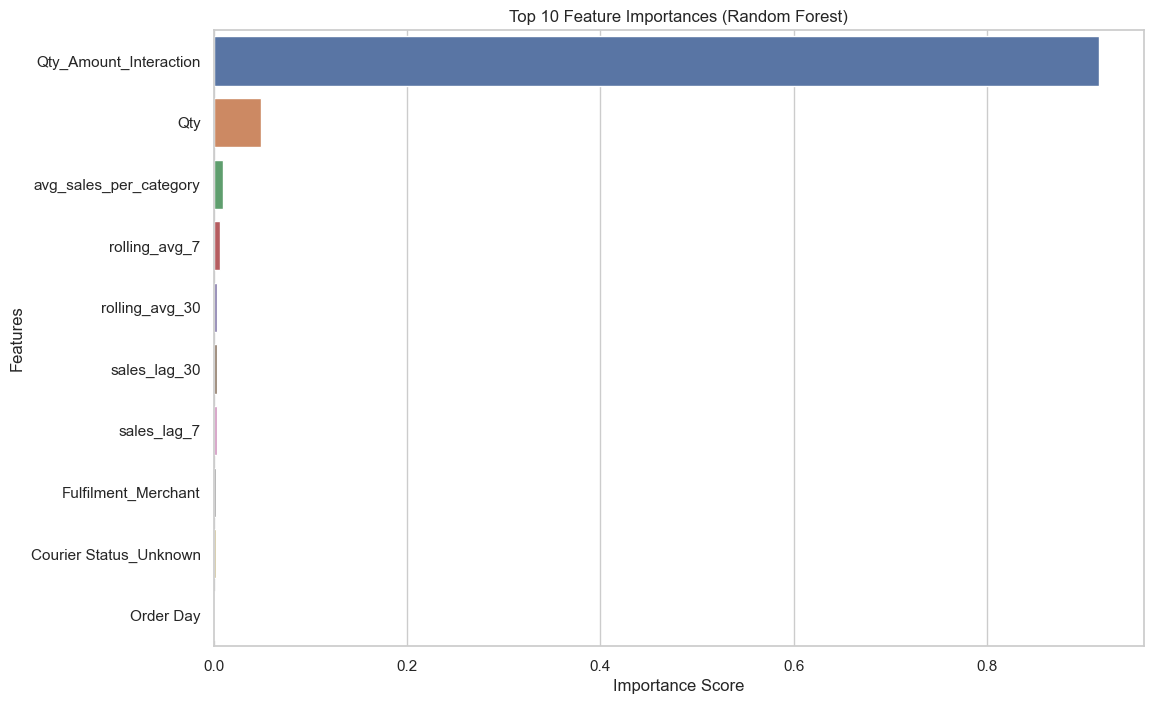

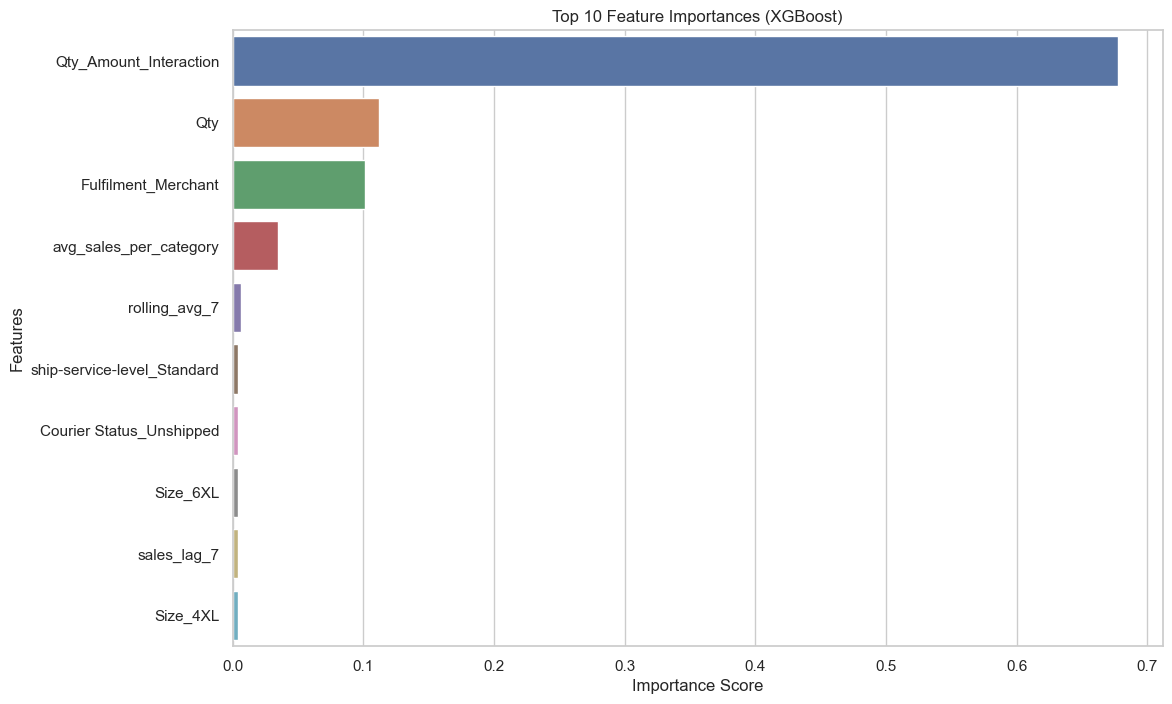

In [24]:
# Function to plot feature importance for all applicable models
def plot_feature_importance_for_all(models_results, feature_names):
    """
    Plot feature importance for all models that support it.
    """
    for model_name, result in models_results.items():
        model = result["model"]
        if hasattr(model, "feature_importances_"):
            feature_importances = model.feature_importances_
            sorted_idx = feature_importances.argsort()[-10:][::-1]  # Top 10 features
            plt.figure(figsize=(12, 8))
            sns.barplot(x=feature_importances[sorted_idx], y=np.array(feature_names)[sorted_idx])
            plt.title(f"Top 10 Feature Importances ({model_name})")
            plt.xlabel("Importance Score")
            plt.ylabel("Features")
            plt.show()

# Visualize feature importance for all models
plot_feature_importance_for_all(results, X_train.columns)


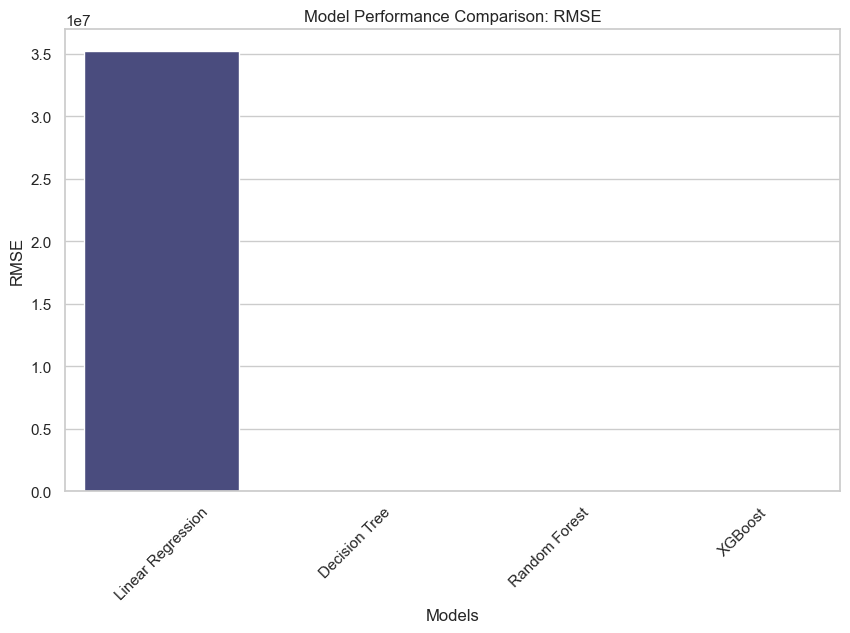

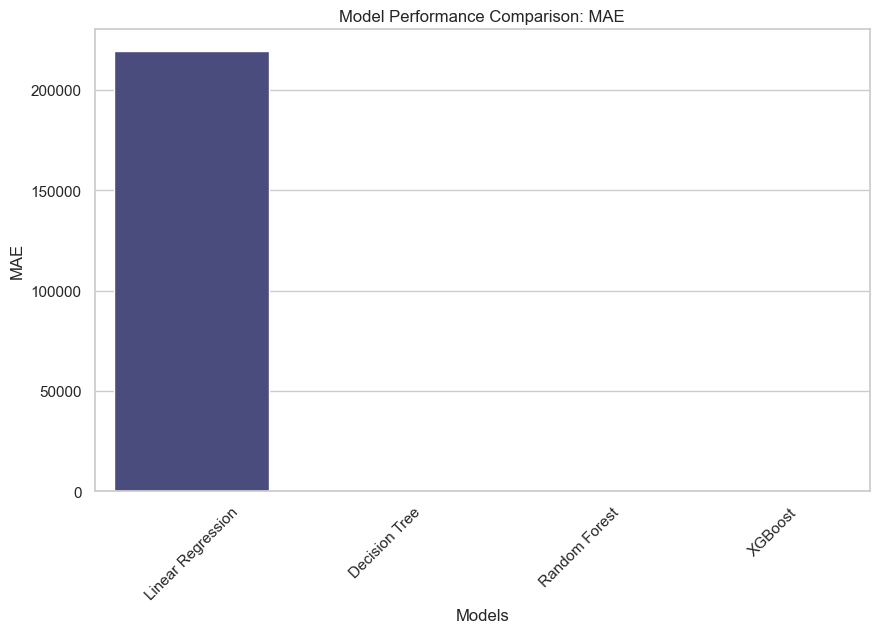

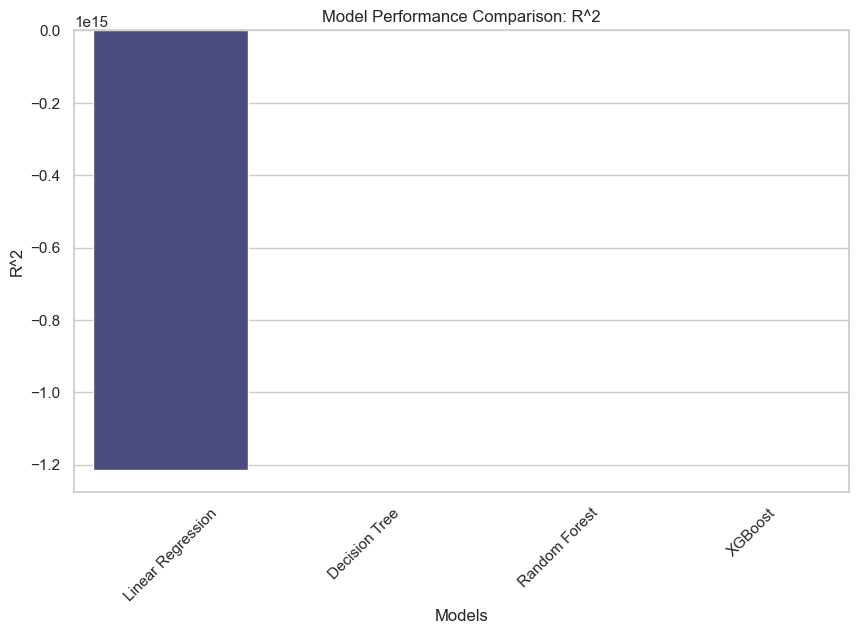

In [25]:
# Function to visualize model performance comparison
def plot_model_performance_comparison(results):
    """
    Create bar charts to compare RMSE, MAE, and R^2 for all models.
    """
    # Extract metrics into a DataFrame
    metrics = ["rmse", "mae", "r2"]
    performance_df = pd.DataFrame({model: {metric: results[model][metric] for metric in metrics} for model in results.keys()}).T
    performance_df.columns = ["RMSE", "MAE", "R^2"]
    performance_df.index.name = "Model"

    # Plot bar chart for each metric
    for metric in performance_df.columns:
        plt.figure(figsize=(10, 6))
        sns.barplot(x=performance_df.index, y=performance_df[metric], palette="viridis")
        plt.title(f"Model Performance Comparison: {metric}")
        plt.ylabel(metric)
        plt.xlabel("Models")
        plt.xticks(rotation=45)
        plt.show()

# Visualize the performance comparison of all models
plot_model_performance_comparison(results)
